# Example #3 Housing Prediction: Chapter 3

Example of regression.

## CPU/GPU Config

Using a GPU for this example is slower than using a CPU (on my system).
The batch size used for training is very low (the number of features is low too) and prevents you from being able to use the GPU effectively.

Some sample average runtimes for training with different batch sizes.

    [With CPU - Batch Size 1]       0 days 00:01:23.265555
    [With CPU - Batch Size 5]       0 days 00:00:17.589785
    [With CPU - Batch Size 10]      0 days 00:00:09.513331
    [With CPU - Batch Size 100]     0 days 00:00:02.192333
    
    [With GPU - Batch Size 1]       0 days 00:04:21.741343
    [With GPU - Batch Size 5]       0 days 00:00:54.128071
    [With GPU - Batch Size 10]      0 days 00:00:28.202666
    [With GPU - Batch Size 100]     0 days 00:00:04.780666

In [1]:
# Force use of CPU - This sample is faster than using a GPU for a small batch size.
# This needs to be done before importing keras or tensorflow.

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import datetime as dt
import pandas as pd
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import boston_housing

Using TensorFlow backend.


## Basic Helpers

In [3]:
def get_time():
    return dt.datetime.now().strftime('%H:%M:%S.%f')

# Load Data

In [4]:
# Get the feature names from the original dataset description.

# http://lib.stat.cmu.edu/datasets/boston
variable_description = """
     CRIM     per capita crime rate by town
     ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
     INDUS    proportion of non-retail business acres per town
     CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
     NOX      nitric oxides concentration (parts per 10 million)
     RM       average number of rooms per dwelling
     AGE      proportion of owner-occupied units built prior to 1940
     DIS      weighted distances to five Boston employment centres
     RAD      index of accessibility to radial highways
     TAX      full-value property-tax rate per $10,000
     PTRATIO  pupil-teacher ratio by town
     B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
     LSTAT    % lower status of the population
     MEDV     Median value of owner-occupied homes in $1000's
"""

variables = []
for line in variable_description.split("\n"):
    parts = line.strip().split()
    if len(parts) >= 1:
        variables.append(parts[0])
        
def make_df(data, targets):
    df = pd.DataFrame(data=data, columns=variables[0:13])
    df[variables[13]] = targets
    return df

In [5]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data_df = make_df(train_data, train_targets)
test_data_df = make_df(test_data, test_targets)

## Explore Data

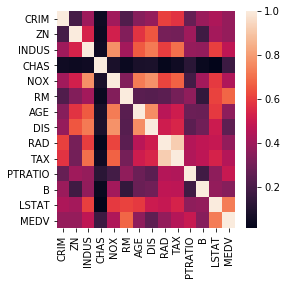

In [6]:
# View feature correlation

td_corr = train_data_df.corr().abs()
plt.figure(figsize = (4,4))
sns.heatmap(td_corr, annot=False)
plt.show()

In [7]:
td_corr[['MEDV']].sort_values(by='MEDV', ascending=False).head(10)

,MEDV
MEDV,1.000000
LSTAT,0.730793
RM,0.681483
PTRATIO,0.493990
INDUS,0.476743
TAX,0.448737
NOX,0.438328
ZN,0.380299
CRIM,0.378498
RAD,0.375515


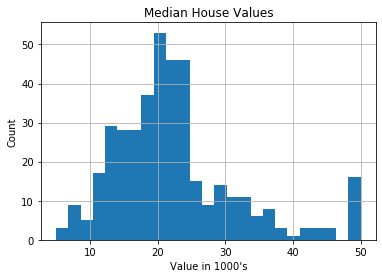

In [8]:
plt.hist(train_targets, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

## Prepare Data

In [9]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

def normalize(data):
    return (data - mean) / std

train_data_df_norm = normalize(train_data_df.loc[:,variables[0:13]])
train_data_df_norm[variables[13]] = train_data_df[variables[13]]

test_data_df_norm = normalize(test_data_df.loc[:,variables[0:13]])
test_data_df_norm[variables[13]] = test_data_df[variables[13]]

## Train Model

In [10]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(len(variables) - 1,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [11]:
k = 4
train_data_df_norm['k'] = [i % k for i in train_data_df_norm.index.values]

num_epochs = 200
batch_size = 1

histories = []

for i in train_data_df_norm.k.unique():
    print(f'[{get_time()}] processing fold # {i}')
    
    train_data = train_data_df_norm[train_data_df_norm.k != i]
    val_data = train_data_df_norm[train_data_df_norm.k == i]
    
    train_x = train_data[variables[0:13]]
    train_y = train_data[variables[13]]
    val_x = val_data[variables[0:13]]
    val_y = val_data[variables[13]]
    
    model = build_model()
    history = model.fit(
        train_x,
        train_y,
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(val_x, val_y)
    )
    histories.append(history)

[18:56:32.963230] processing fold # 0
[18:57:55.044902] processing fold # 1
[18:59:15.545447] processing fold # 2
[19:00:37.950926] processing fold # 3


In [12]:
def history_to_df(h):
    h_df = pd.DataFrame(h.history)
    h_df['epoch'] = h_df.index.values + 1
    return h_df

history = pd.concat(history_to_df(h) for h in histories)
h_avgs = history.groupby('epoch').mean()

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

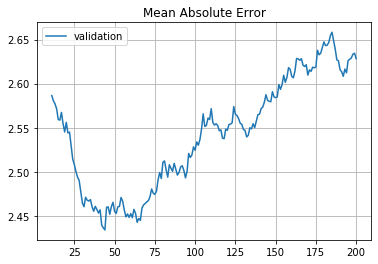

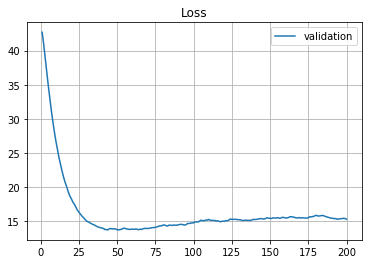

In [14]:
#plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.mae[10:]), "-", label="train")
plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.val_mae[10:]), "-", label="validation")
plt.grid()
plt.title("Mean Absolute Error")
plt.legend()
plt.show()

#plt.plot(h_avgs.index, h_avgs.loss, "-", label="train")
plt.plot(h_avgs.index, smooth_curve(h_avgs.val_loss), "-", label="validation")
plt.grid()
plt.title("Loss")
plt.legend()
plt.show()

## Train Model

In [16]:
model = build_model()
num_epochs = 70
model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]],
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=0
)

## Evaluate Test Results

In [17]:
val_mse, val_mae = model.evaluate(
    test_data_df_norm[variables[0:13]],
    test_data_df_norm[variables[13]],
    verbose=0)

print(val_mse)
print(val_mae)

13.593618056353401
2.326547622680664


In [18]:
test_data_df['Predicted'] = [r[0] for r in model.predict(test_data_df_norm[variables[0:13]])]

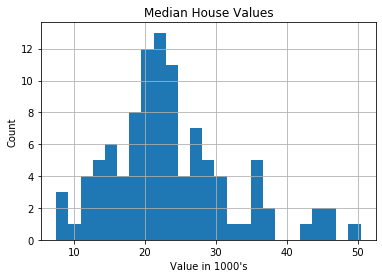

In [19]:
plt.hist(test_data_df.Predicted, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

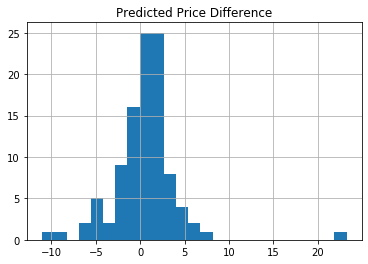

In [20]:
plt.hist(test_data_df.Predicted - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()

## See How XGBoost Compares

In [34]:
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [54]:
# Train with k-fold validation

def xgb_train_w_validation(model):
    mae_s = []
    val_mae_s = []
    for k in train_data_df_norm.k.unique():
        train_data = train_data_df_norm[train_data_df_norm.k != k]
        val_data = train_data_df_norm[train_data_df_norm.k == k]
        xgb_model.fit(
            train_data[variables[0:13]],
            train_data[variables[13]].values
        )
        
        xgb_results = xgb_model.predict(train_data[variables[0:13]])
        mae = sklearn.metrics.mean_absolute_error(train_data[variables[13]].values, xgb_results)
        mae_s.append(mae)
        
        xgb_results_val = xgb_model.predict(val_data[variables[0:13]])
        val_mae = sklearn.metrics.mean_absolute_error(val_data[variables[13]].values, xgb_results_val)
        val_mae_s.append(val_mae)
        
    return (np.mean(mae_s), np.mean(val_mae_s))

In [71]:
# Try different hyper parameters
all_results = []
for max_depth in [2, 5, 7, 10]:
    for n_estimators in [100, 200, 300, 500]:
        for learning_rate in [0.1, 0.2, 0.3, 0.4]:
            for alpha in [5]:
                params = dict(
                    objective ='reg:squarederror',
                    learning_rate = learning_rate,
                    max_depth = max_depth,
                    alpha = alpha,
                    n_estimators = n_estimators
                )
                xgb_model = xgb.XGBRegressor(**params)
                (mae, val_mae) = xgb_train_w_validation(xgb_model)
                results = dict(**params)
                results['mae'] = mae
                results['val_mae'] = val_mae
                all_results.append(results)
            
all_results = pd.DataFrame(all_results)
all_results = all_results.sort_values(by='val_mae', ascending=True)

display(all_results.head(5))
display(all_results.corr()[['val_mae']])

,objective,learning_rate,max_depth,alpha,n_estimators,mae,val_mae
20,reg:squarederror,0.1,5,5,200,0.121322,2.216854
24,reg:squarederror,0.1,5,5,300,0.037651,2.217035
28,reg:squarederror,0.1,5,5,500,0.004916,2.217955
17,reg:squarederror,0.2,5,5,100,0.108403,2.231613
21,reg:squarederror,0.2,5,5,200,0.010175,2.234785


,val_mae
learning_rate,0.547923
max_depth,-0.265899
alpha,NaN
n_estimators,-0.054078
mae,0.404073
val_mae,1.000000


In [74]:
# Train model with chosen hyper parameters all the entire training set.
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror',
    learning_rate = 0.1,
    max_depth = 5,
    alpha = 5,
    n_estimators = 200
)

xgb_model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]].values
)

# Show test metrics
xgb_t_results = xgb_model.predict(test_data_df_norm[variables[0:13]])
test_mae = sklearn.metrics.mean_absolute_error(test_data_df_norm[variables[13]].values, xgb_t_results)
print(f"Test MAE: {test_mae}")

Test MAE: 2.2463971942078835


In [73]:
# Show features by importance
features = pd.DataFrame()
features['name'] = variables[0:13]
features['importance'] = xgb_model.feature_importances_
features = features.sort_values(by='importance', ascending=False)
features

,name,importance
12,LSTAT,0.536317
5,RM,0.212380
7,DIS,0.065160
4,NOX,0.050365
9,TAX,0.031766
10,PTRATIO,0.029733
0,CRIM,0.022502
8,RAD,0.017404
11,B,0.009375
6,AGE,0.009117


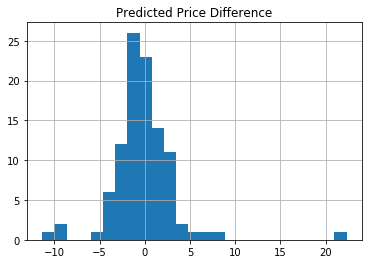

In [75]:
plt.hist(xgb_t_results - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()